In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats
from sklearn.preprocessing import LabelBinarizer,RobustScaler, StandardScaler, MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, ElasticNet, Ridge
from sklearn.svm import LinearSVR

data = pd.read_csv("data\Steel_industry_data.csv")
data.head()

ModuleNotFoundError: No module named 'pandas'

### Checking the number of rows and columns

In [5]:
data.shape

(35040, 11)

### Information about the data

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35040 entries, 0 to 35039
Data columns (total 11 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   date                                  35040 non-null  object 
 1   Usage_kWh                             35040 non-null  float64
 2   Lagging_Current_Reactive.Power_kVarh  35040 non-null  float64
 3   Leading_Current_Reactive_Power_kVarh  35040 non-null  float64
 4   CO2(tCO2)                             35040 non-null  float64
 5   Lagging_Current_Power_Factor          35040 non-null  float64
 6   Leading_Current_Power_Factor          35040 non-null  float64
 7   NSM                                   35040 non-null  int64  
 8   WeekStatus                            35040 non-null  object 
 9   Day_of_week                           35040 non-null  object 
 10  Load_Type                             35040 non-null  object 
dtypes: float64(6), 

### Checking missing values

In [7]:
data.isnull().sum()

date                                    0
Usage_kWh                               0
Lagging_Current_Reactive.Power_kVarh    0
Leading_Current_Reactive_Power_kVarh    0
CO2(tCO2)                               0
Lagging_Current_Power_Factor            0
Leading_Current_Power_Factor            0
NSM                                     0
WeekStatus                              0
Day_of_week                             0
Load_Type                               0
dtype: int64

### Identify duplicates

In [8]:
dups = data.duplicated()
data[dups]

,date,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type


### Identify mistyped data

Check numeric

In [9]:
numeric = data.applymap(lambda x: isinstance(x, (int, float)))['Usage_kWh']
data[~numeric]

,date,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type


Check string

In [10]:
strings = data.applymap(lambda x: isinstance(x, (str)))['Day_of_week']
data[~strings]

,date,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type


### Columns info

Column 'WeekStatus' values:

In [11]:
data['WeekStatus'].value_counts()

Weekday    25056
Weekend     9984
Name: WeekStatus, dtype: int64

Column 'Load_Type' values:

In [12]:
data['Load_Type'].value_counts()

Light_Load      18072
Medium_Load      9696
Maximum_Load     7272
Name: Load_Type, dtype: int64

Mean value

In [13]:
data.mean(numeric_only=True)

Usage_kWh                                  27.386892
Lagging_Current_Reactive.Power_kVarh       13.035384
Leading_Current_Reactive_Power_kVarh        3.870949
CO2(tCO2)                                   0.011524
Lagging_Current_Power_Factor               80.578056
Leading_Current_Power_Factor               84.367870
NSM                                     42750.000000
dtype: float64

Median value

In [14]:
data.median(numeric_only=True)

Usage_kWh                                   4.57
Lagging_Current_Reactive.Power_kVarh        5.00
Leading_Current_Reactive_Power_kVarh        0.00
CO2(tCO2)                                   0.00
Lagging_Current_Power_Factor               87.96
Leading_Current_Power_Factor              100.00
NSM                                     42750.00
dtype: float64

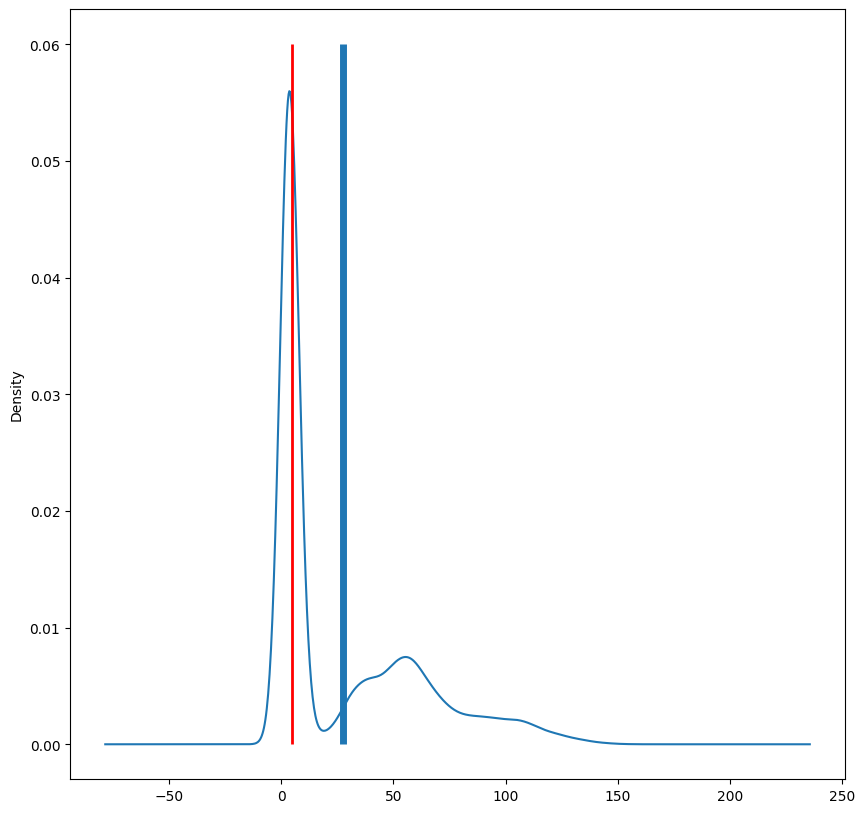

In [15]:
data['Usage_kWh'].plot(kind="density", figsize=(10,10))
plt.vlines(data['Usage_kWh'].mean(), ymin = 0, ymax = 0.06, linewidth = 5.0)
plt.vlines(data['Usage_kWh'].median(), ymin=0, ymax=0.06, linewidth=2.0, color="red")

Mode value

In [16]:
data.mode()

,date,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type
0,01/01/2018 00:00,3.06,0.0,0.0,0.0,100.0,100.0,0.0,Weekday,Monday,Light_Load
1,01/01/2018 00:15,NaN,NaN,NaN,NaN,NaN,NaN,900.0,NaN,NaN,NaN
2,01/01/2018 00:30,NaN,NaN,NaN,NaN,NaN,NaN,1800.0,NaN,NaN,NaN
3,01/01/2018 00:45,NaN,NaN,NaN,NaN,NaN,NaN,2700.0,NaN,NaN,NaN
4,01/01/2018 01:00,NaN,NaN,NaN,NaN,NaN,NaN,3600.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
35035,31/12/2018 22:45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35036,31/12/2018 23:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35037,31/12/2018 23:15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35038,31/12/2018 23:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Variance

In [17]:
data['Usage_kWh'].var()

1118.5265340538938

Standard deviation

In [18]:
data['Usage_kWh'].std()

33.44437970801513

Percentiles

In [19]:
percentiles = np.percentile(data['Usage_kWh'], [0, 25, 50, 75, 100])
percentiles

array([  0.    ,   3.2   ,   4.57  ,  51.2375, 157.18  ])

'Usage_kWh' column description:

In [20]:
desc_stat = scipy.stats.describe(data['Usage_kWh'], ddof = 1, bias = False)
desc_stat

DescribeResult(nobs=35040, minmax=(0.0, 157.18), mean=27.386892408675795, variance=1118.526534053894, skewness=1.1973938227692211, kurtosis=0.3913856014239281)

Data description

In [21]:
data.describe()

,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM
count,35040.000000,35040.000000,35040.000000,35040.000000,35040.000000,35040.000000,35040.000000
mean,27.386892,13.035384,3.870949,0.011524,80.578056,84.367870,42750.000000
std,33.444380,16.306000,7.424463,0.016151,18.921322,30.456535,24940.534317
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.200000,2.300000,0.000000,0.000000,63.320000,99.700000,21375.000000
50%,4.570000,5.000000,0.000000,0.000000,87.960000,100.000000,42750.000000
75%,51.237500,22.640000,2.090000,0.020000,99.022500,100.000000,64125.000000
max,157.180000,96.910000,27.760000,0.070000,100.000000,100.000000,85500.000000


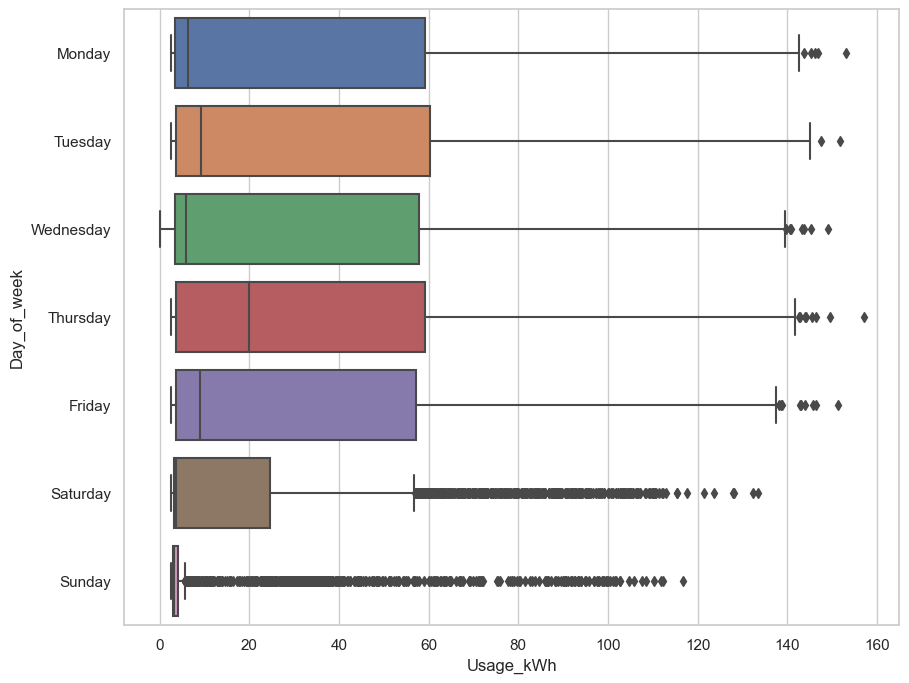

In [22]:
sns.set(style="whitegrid")
plt.figure(figsize=(10,8))
ax = sns.boxplot(x='Usage_kWh', data=data, y='Day_of_week', orient="h")

C:\Users\Tea\AppData\Local\Temp\ipykernel_7796\1477773921.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation = data.corr()


<AxesSubplot: >

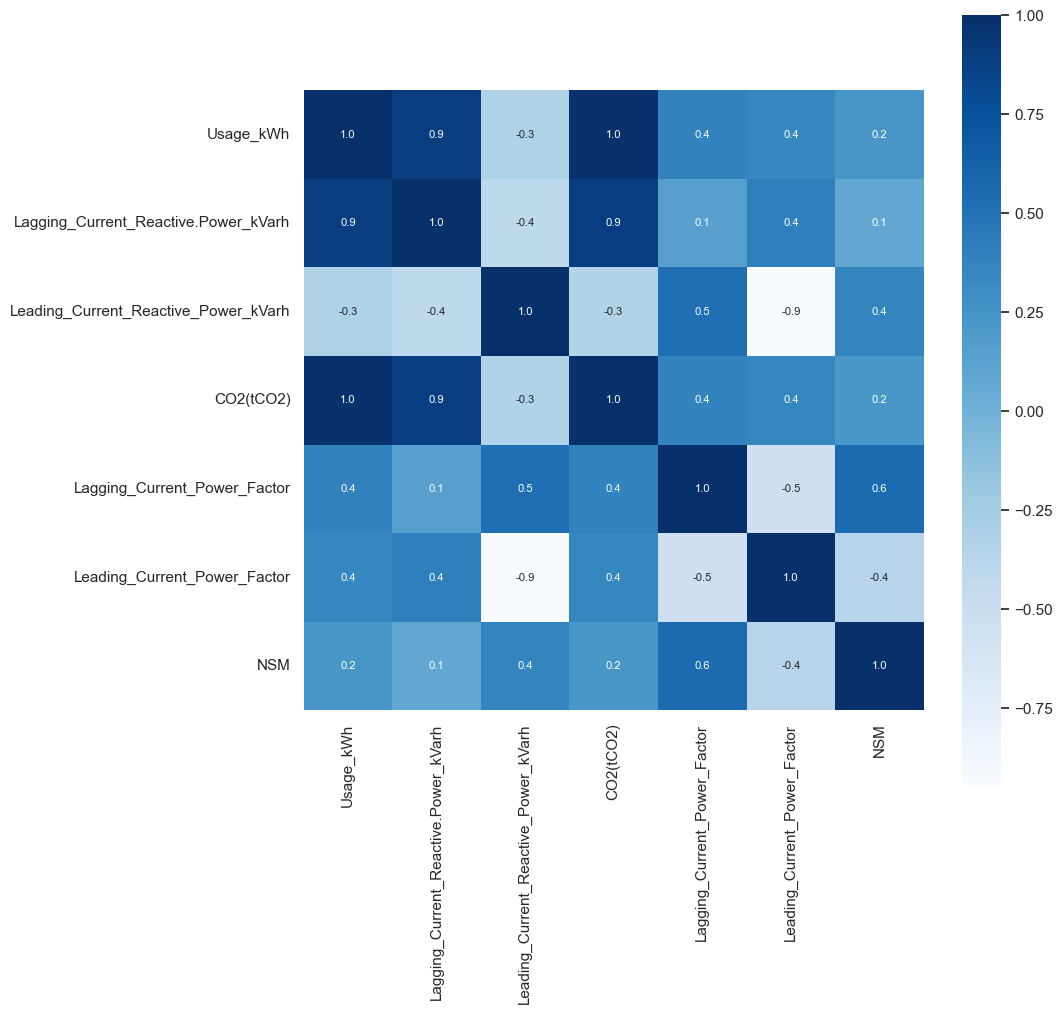

In [23]:
correlation = data.corr()
plt.figure(figsize=(10,10))
sns.heatmap(correlation, cbar=True, square=True, fmt='.1f', annot=True, annot_kws={'size':8}, cmap='Blues')


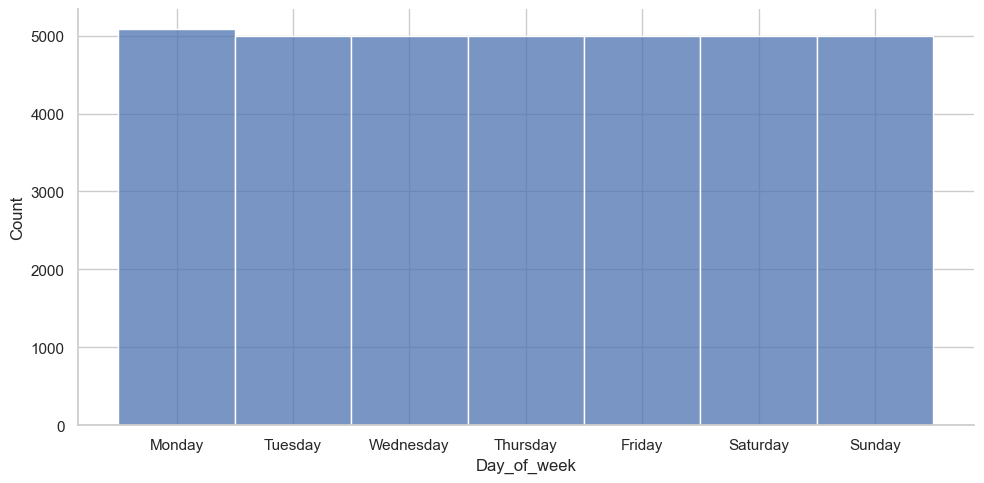

In [24]:
sns.displot(data['Day_of_week'], height=5, aspect=2)

{'whiskers': [<matplotlib.lines.Line2D at 0x260ba24bd60>,
 'caps': [<matplotlib.lines.Line2D at 0x260baad01c0>,
 'boxes': [<matplotlib.lines.Line2D at 0x260ba24bac0>,
 'medians': [<matplotlib.lines.Line2D at 0x260baad0700>,
 'fliers': [<matplotlib.lines.Line2D at 0x260baad09a0>,
 'means': []}

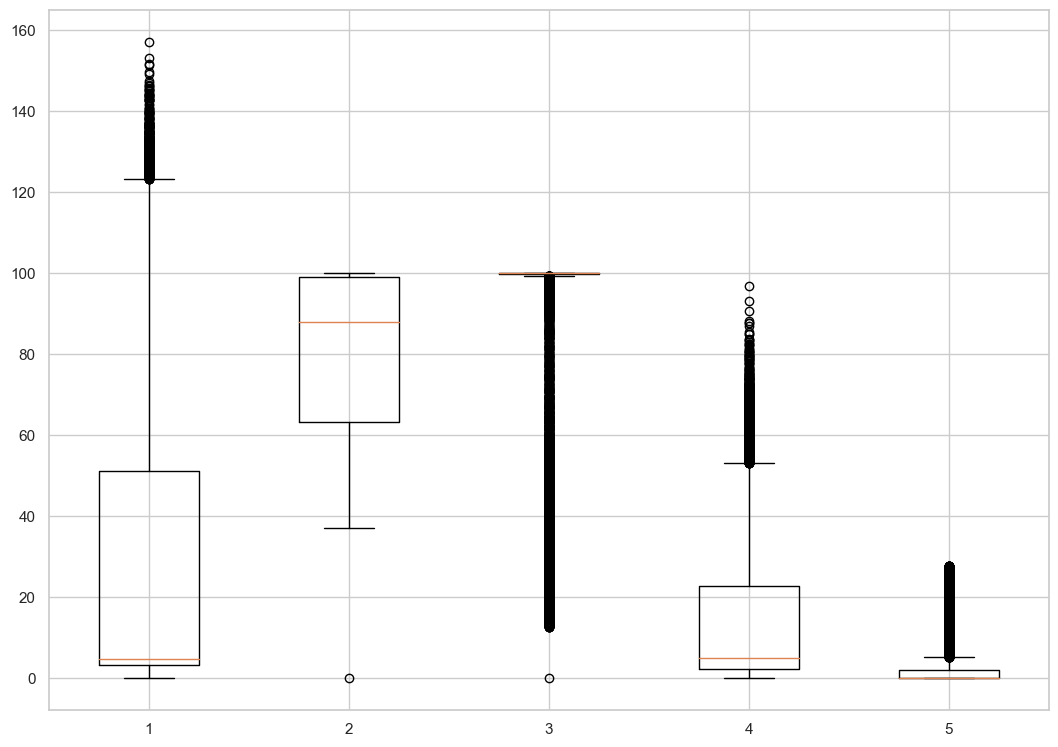

In [25]:
fig = plt.figure(figsize =(10, 7))
ax = fig.add_axes([0, 0, 1, 1])
ax.boxplot([data['Usage_kWh'], data['Lagging_Current_Power_Factor'], data['Leading_Current_Power_Factor'], data['Lagging_Current_Reactive.Power_kVarh'], data['Leading_Current_Reactive_Power_kVarh']])

Encoding Nominal Categorial Data

In [26]:
one_hot = LabelBinarizer()

encoded_weekstatus = one_hot.fit_transform(data['WeekStatus'])
data['WeekStatus'] = one_hot.fit_transform(data['WeekStatus'])
print(one_hot.classes_)
print(encoded_weekstatus)

encoded_load_type = one_hot.fit_transform(data['Load_Type'])
data['Load_Type'] = one_hot.fit_transform(data['Load_Type'])

print(one_hot.classes_)
encoded_load_type

['Weekday' 'Weekend']
[[0]
 [0]
 [0]
 ...
 [0]
 [0]
 [0]]
['Light_Load' 'Maximum_Load' 'Medium_Load']


array([[1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       ...,
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0]])

Encoding Ordinal Categorial Data

In [27]:
scale_mapper = {"Monday": 1,
                "Tuesday": 2,
                "Wednesday": 3,
                "Thursday": 4,
                "Friday": 5,
                "Saturday": 6,
                "Sunday": 7}

encoded_day_of_week = data['Day_of_week'].replace(scale_mapper)
data['Day_of_week'] = data['Day_of_week'].replace(scale_mapper)

print(data['Day_of_week'].value_counts())
#encoded_day_of_week.value_counts()

1    5088
2    4992
3    4992
4    4992
5    4992
6    4992
7    4992
Name: Day_of_week, dtype: int64


C:\Users\Tea\AppData\Local\Temp\ipykernel_7796\2644994958.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation = data.corr()


<AxesSubplot: >

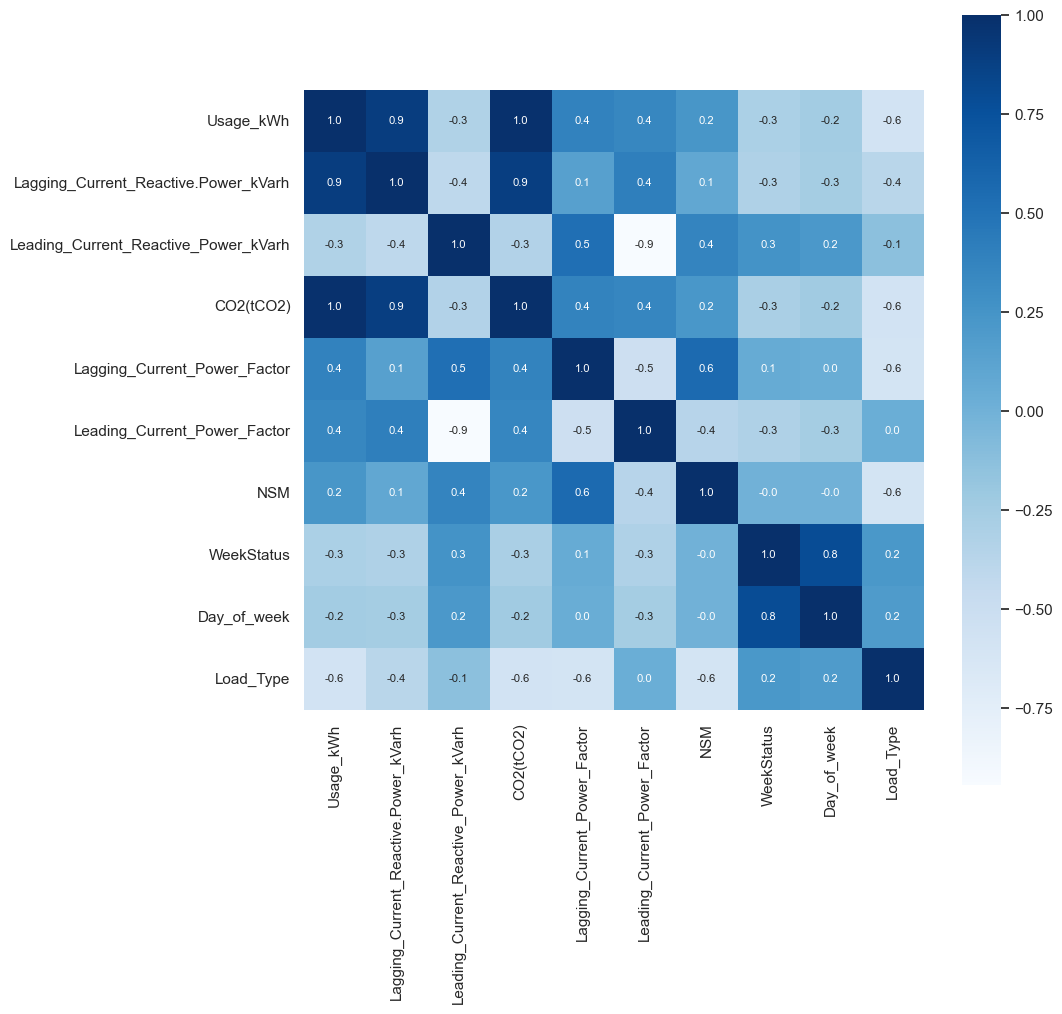

In [28]:
correlation = data.corr()
plt.figure(figsize=(10,10))
sns.heatmap(correlation, cbar=True, square=True, fmt='.1f', annot=True, annot_kws={'size':8}, cmap='Blues')

Testing different Regression Models with all features

In [29]:
temp = data.loc[:, data.columns != 'Usage_kWh']
features, target = temp.loc[:, temp.columns != 'date'], data['Usage_kWh']
features_train, features_test, target_train, target_test = train_test_split(features, target, random_state=0)

dummy = DummyRegressor(strategy="mean")
dummy.fit(features_train, target_train)
d_score = dummy.score(features_test, target_test)

clf = DummyRegressor(strategy='constant', constant=20)
clf.fit(features_train, target_train)
clf_score = clf.score(features_test, target_test)

lr = LinearRegression()
lr.fit(features_train, target_train)
lr_score = lr.score(features_test, target_test)

lasso = Lasso(alpha=0.1)
lasso.fit(features_train, target_train)
llr_score = lasso.score(features_train, target_train)

en = ElasticNet(alpha=0.1)
en.fit(features_train, target_train)
en_score = en.score(features_train, target_train)

rlr = Ridge(alpha=0.1)
rlr.fit(features_train, target_train)
rlr_score = rlr.score(features_train, target_train)

scaler = MinMaxScaler()
features_train = scaler.fit_transform(features_train)
features_test = scaler.transform(features_test)
svr = LinearSVR()
svr.fit(features_train, target_train)
svr_score_1 = svr.score(features_train, target_train)

scaler = StandardScaler()
features_train = scaler.fit_transform(features_train)
features_test = scaler.transform(features_test)
svr = LinearSVR()
svr.fit(features_train, target_train)
svr_score_2 = svr.score(features_train, target_train)

print("Dummy (mean) score: " + str(d_score))
print("vs")
print("Dummy (constant) score: " + str(clf_score))
print("vs")
print("Linear regression score: " + str(lr_score))
print("vs")
print("Lasso regression score: " + str(llr_score))
print("vs")
print("ElasticNet regression score: " + str(en_score))
print("vs")
print("Ridge regression score: " + str(rlr_score))
print("vs")
print("Linear SVR regression score with minmax scaler: " + str(svr_score_1))
print("vs")
print("Linear SVR regression score with standard scaler: " + str(svr_score_2))

Dummy (mean) score: -0.0001589100299508317
vs
Dummy (constant) score: -0.04587744103278535
vs
Linear regression score: 0.978010134179461
vs
Lasso regression score: 0.9170918403753938
vs
ElasticNet regression score: 0.9164948757988141
vs
Ridge regression score: 0.9800663473974041
vs
Linear SVR regression score with minmax scaler: 0.980700337208835
vs
Linear SVR regression score with standard scaler: 0.9807345225778069


Describing data after removing row with all zeroes

In [30]:
data = data[data['Usage_kWh'] != 0]

data.describe()

,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type
count,35039.000000,35039.000000,35039.000000,35039.000000,35039.000000,35039.000000,35039.000000,35039.000000,35039.000000,35039.000000
mean,27.387674,13.035756,3.871059,0.011525,80.580356,84.370278,42751.220069,0.284940,3.991809,0.515740
std,33.444537,16.306084,7.424540,0.016151,18.916695,30.453634,24939.844508,0.451392,2.003455,0.499759
min,2.450000,0.000000,0.000000,0.000000,36.940000,12.500000,0.000000,0.000000,1.000000,0.000000
25%,3.200000,2.300000,0.000000,0.000000,63.320000,99.700000,21600.000000,0.000000,2.000000,0.000000
50%,4.570000,5.000000,0.000000,0.000000,87.960000,100.000000,43200.000000,0.000000,4.000000,1.000000
75%,51.245000,22.640000,2.090000,0.020000,99.025000,100.000000,64350.000000,1.000000,6.000000,1.000000
max,157.180000,96.910000,27.760000,0.070000,100.000000,100.000000,85500.000000,1.000000,7.000000,1.000000


In [31]:
temp = data.loc[:, data.columns != 'Usage_kWh']
features, target = temp.loc[:, temp.columns != 'date'], data['Usage_kWh']
features_train, features_test, target_train, target_test = train_test_split(features, target, random_state=0)
scaler = RobustScaler()
features_train = scaler.fit_transform(features_train)
features_test = scaler.transform(features_test)
model = LinearRegression()
model.fit(features_train, target_train)
robust_score = model.score(features_test, target_test)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(features_train)
X_test = scaler.transform(features_test)
model = LinearRegression()
model.fit(features_train, target_train)
minmax_score = model.score(features_test, target_test)

scaler = StandardScaler()
features_train = scaler.fit_transform(features_train)
features_test = scaler.transform(features_test)
model = LinearRegression()
model.fit(features_train, target_train)
standard_score = model.score(features_test, target_test)
print(robust_score)
print(minmax_score)
print(standard_score)

nof_list=np.arange(1,9)
high_score=0

0.9780123779959484
0.9780123779959484
0.9780123779959484


<h3>Linear Regression</h3>

Grid and Random Search for hyperparameters

In [1]:
data = data.loc[:, data.columns != 'date']
features, target = data.loc[:, data.columns != 'Usage_kWh'], data['Usage_kWh']
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.3, random_state=0)

model = LinearRegression()

space = dict()
space['fit_intercept'] = [True, False]

grid_search = GridSearchCV(model, space, scoring='neg_mean_absolute_error', n_jobs=8, cv=10)
randomized_search = RandomizedSearchCV(model, space, scoring='neg_mean_absolute_error')

grid_result = grid_search.fit(features_train, target_train)
randomized_result = randomized_search.fit(features_train, target_train)

print('Grid Search - Best Score: %s' % grid_result.best_score_)
print('Grid Search - Best Hyperparameters: %s' % grid_result.best_params_)
print('Randomized Search - Best Score: %s' % randomized_result.best_score_)
print('Randomized Search - Best Hyperparameters: %s' % randomized_result.best_params_)

NameError: name 'data' is not defined

RFE Method for feature selection

In [33]:
nof_list=np.arange(1,9)            
high_score=0

nof=0           
score_list =[]
for n in range(len(nof_list)):
    features, target = data.loc[:, data.columns != 'Usage_kWh'], data['Usage_kWh']
    features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.3, random_state=0)

    model = LinearRegression(fit_intercept=True)
    rfe = RFE(estimator=model, n_features_to_select=nof_list[n])
    features_train_rfe = rfe.fit_transform(features_train,target_train)
    features_test_rfe = rfe.transform(features_test)
    model.fit(features_train_rfe, target_train)
    score = model.score(features_test_rfe, target_test)
    score_list.append(score)
    if(score>high_score):
        high_score = score
        nof = nof_list[n]
print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))

Optimum number of features: 8
Score with 8 features: 0.978820


In [34]:
features, target = data.loc[:, data.columns != 'Usage_kWh'], data['Usage_kWh']
cols = list(features.columns)
model = LinearRegression(fit_intercept=True)
rfe = RFE(estimator=model, n_features_to_select=8)             
features_rfe = rfe.fit_transform(features, target)  
model.fit(features_rfe, target)              
temp = pd.Series(rfe.support_,index = cols)
selected_features_rfe = temp[temp==True].index
print(selected_features_rfe)

Index(['Lagging_Current_Reactive.Power_kVarh',
       'Leading_Current_Reactive_Power_kVarh', 'CO2(tCO2)',
       'Lagging_Current_Power_Factor', 'Leading_Current_Power_Factor',
       'WeekStatus', 'Day_of_week', 'Load_Type'],
      dtype='object')


Testing model with hyperparameters and selected features

In [64]:
features, target = data.loc[:, data.columns != 'Usage_kWh'], data['Usage_kWh']
features = features.loc[:, features.columns != 'NSM']
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.3, random_state=0)
model = LinearRegression(fit_intercept=True)
model.fit(features_train, target_train)

train_score = model.score(features_train, target_train)
test_score = model.score(features_test, target_test)

print("The train score for LR model is {}".format(train_score))
print("The test score for LR model is {}".format(test_score))

The train score for LR model is 0.9810272405473877
The test score for LR model is 0.9788200200133501


<h3>Ridge Regression</h3>

Grid Search for hyperparameters

In [50]:
data = data.loc[:, data.columns != 'date']
features, target = data.loc[:, data.columns != 'Usage_kWh'], data['Usage_kWh']
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.3, random_state=0)

model = Ridge()

space = dict()
space['solver'] = ['svd', 'lsqr', 'sag']
space['alpha'] = [0.0001, 0.001, 0.01, 0.1, 1, 10]
space['fit_intercept'] = [True, False]

grid_search = GridSearchCV(model, space, scoring='neg_mean_absolute_error', n_jobs=8, cv=10)
randomized_search = RandomizedSearchCV(model, space, scoring='neg_mean_absolute_error', n_jobs=8, cv=10)

grid_result = grid_search.fit(features_train, target_train)
randomized_result = randomized_search.fit(features_train, target_train)

print('Grid Search - Best Score: %s' % grid_result.best_score_)
print('Grid Search - Best Hyperparameters: %s' % grid_result.best_params_)
print('Randomized Search - Best Score: %s' % randomized_result.best_score_)
print('Randomized Search - Best Hyperparameters: %s' % randomized_result.best_params_)

Grid Search - Best Score: -2.531149694087877
Grid Search - Best Hyperparameters: {'alpha': 0.0001, 'fit_intercept': True, 'solver': 'svd'}
Randomized Search - Best Score: -2.533612484070061
Randomized Search - Best Hyperparameters: {'solver': 'svd', 'fit_intercept': True, 'alpha': 0.001}


RFE Method for feature selection

In [37]:
nof_list=np.arange(1,9)            
high_score=0

nof=0           
score_list =[]
for n in range(len(nof_list)):
    features, target = data.loc[:, data.columns != 'Usage_kWh'], data['Usage_kWh']
    features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.3, random_state=0)

    model = Ridge(alpha=0.0001, fit_intercept=True, solver='svd')
    rfe = RFE(estimator=model, n_features_to_select=nof_list[n])
    features_train_rfe = rfe.fit_transform(features_train,target_train)
    features_test_rfe = rfe.transform(features_test)
    model.fit(features_train_rfe, target_train)
    score = model.score(features_test_rfe, target_test)
    score_list.append(score)
    if(score>high_score):
        high_score = score
        nof = nof_list[n]
print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))

Optimum number of features: 8
Score with 8 features: 0.978820


In [38]:
features, target = data.loc[:, data.columns != 'Usage_kWh'], data['Usage_kWh']
cols = list(features.columns)
model = Ridge(alpha=0.0001, fit_intercept=True, solver='svd')
rfe = RFE(estimator=model, n_features_to_select=8)             
features_rfe = rfe.fit_transform(features, target)  
model.fit(features_rfe, target)              
temp = pd.Series(rfe.support_,index = cols)
selected_features_rfe = temp[temp==True].index
print(selected_features_rfe)

Index(['Lagging_Current_Reactive.Power_kVarh',
       'Leading_Current_Reactive_Power_kVarh', 'CO2(tCO2)',
       'Lagging_Current_Power_Factor', 'Leading_Current_Power_Factor',
       'WeekStatus', 'Day_of_week', 'Load_Type'],
      dtype='object')


Testing model with hyperparameters and selected features

In [53]:
features, target = data.loc[:, data.columns != 'Usage_kWh'], data['Usage_kWh']
features = features.loc[:, features.columns != 'NSM']
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.3, random_state=0)
model =  Ridge(alpha=0.0001, fit_intercept=True, solver='svd')
model.fit(features_train, target_train)

train_score = model.score(features_train, target_train)
test_score = model.score(features_test, target_test)

print("The train score for ridge model (alpha=0.0001) is {}".format(train_score))
print("The test score for ridge model (alpha=0.0001) is {}".format(test_score))

model =  Ridge(alpha=0.001, fit_intercept=True, solver='svd')
model.fit(features_train, target_train)

train_score = model.score(features_train, target_train)
test_score = model.score(features_test, target_test)

print("The train score for ridge model (alpha=0.001) is {}".format(train_score))
print("The test score for ridge model (alpha=0.001) is {}".format(test_score))

The train score for ridge model (alpha=0.0001) is 0.9810272389259523
The test score for ridge model (alpha=0.0001) is 0.9788204516050687
The train score for ridge model (alpha=0.001) is 0.9810270788683053
The test score for ridge model (alpha=0.001) is 0.9788241815333608


<h3>Lasso Regression</h3>

Grid Search for hyperparameters

In [54]:
features, target = data.loc[:, data.columns != 'Usage_kWh'], data['Usage_kWh']
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.3, random_state=0)

model = Lasso()

space = dict()
space['alpha'] = [0.0001, 0.001, 0.01, 0.1, 1, 10]
space['fit_intercept'] = [True, False]

grid_search = GridSearchCV(model, space, scoring='neg_mean_absolute_error', n_jobs=8, cv=10)
randomized_search = RandomizedSearchCV(model, space, scoring='neg_mean_absolute_error', n_jobs=8, cv=10)

grid_result = grid_search.fit(features_train, target_train)
randomized_result = randomized_search.fit(features_train, target_train)

print('Grid Search - Best Score: %s' % grid_result.best_score_)
print('Grid Search - Best Hyperparameters: %s' % grid_result.best_params_)
print('Randomized Search - Best Score: %s' % randomized_result.best_score_)
print('Randomized Search - Best Hyperparameters: %s' % randomized_result.best_params_)

Grid Search - Best Score: -2.5344333564492594
Grid Search - Best Hyperparameters: {'alpha': 0.0001, 'fit_intercept': True}
Randomized Search - Best Score: -2.5344333564492594
Randomized Search - Best Hyperparameters: {'fit_intercept': True, 'alpha': 0.0001}


RFE Method for feature selection

In [41]:
nof_list=np.arange(1,9)            
high_score=0

nof=0           
score_list =[]
for n in range(len(nof_list)):
    features, target = data.loc[:, data.columns != 'Usage_kWh'], data['Usage_kWh']
    features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.3, random_state=0)

    model = Lasso(alpha=0.0001, fit_intercept=True)
    rfe = RFE(estimator=model, n_features_to_select=nof_list[n])
    features_train_rfe = rfe.fit_transform(features_train,target_train)
    features_test_rfe = rfe.transform(features_test)
    model.fit(features_train_rfe, target_train)
    score = model.score(features_test_rfe, target_test)
    score_list.append(score)
    if(score>high_score):
        high_score = score
        nof = nof_list[n]
print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))

Optimum number of features: 8
Score with 8 features: 0.978826


In [42]:
features, target = data.loc[:, data.columns != 'Usage_kWh'], data['Usage_kWh']
cols = list(features.columns)
model = Lasso(alpha=0.0001, fit_intercept=True)
rfe = RFE(estimator=model, n_features_to_select=8)             
features_rfe = rfe.fit_transform(features, target)  
model.fit(features_rfe, target)              
temp = pd.Series(rfe.support_,index = cols)
selected_features_rfe = temp[temp==True].index
print(selected_features_rfe)

Index(['Lagging_Current_Reactive.Power_kVarh',
       'Leading_Current_Reactive_Power_kVarh', 'CO2(tCO2)',
       'Lagging_Current_Power_Factor', 'Leading_Current_Power_Factor',
       'WeekStatus', 'Day_of_week', 'Load_Type'],
      dtype='object')


Testing model with hyperparameters and selected features

In [43]:
features, target = data.loc[:, data.columns != 'Usage_kWh'], data['Usage_kWh']
features = features.loc[:, features.columns != 'NSM']
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.3, random_state=0)
model = Lasso(alpha=0.0001, fit_intercept=True)
model.fit(features_train, target_train)

train_score = model.score(features_train, target_train)
test_score = model.score(features_test, target_test)

print("The train score for ridge model is {}".format(train_score))
print("The test score for ridge model is {}".format(test_score))

The train score for ridge model is 0.9810268960946551
The test score for ridge model is 0.9788259551480127


<h3>ElasticNet</h3>

Grid Search for hyperparameters

In [55]:
features, target = data.loc[:, data.columns != 'Usage_kWh'], data['Usage_kWh']
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.3, random_state=0)

model = ElasticNet()

space = dict()
space['alpha'] = [0.0001, 0.001, 0.01, 0.1, 1, 10]
space['fit_intercept'] = [True, False]

grid_search = GridSearchCV(model, space, scoring='neg_mean_absolute_error', n_jobs=8, cv=10)
randomized_search = RandomizedSearchCV(model, space, scoring='neg_mean_absolute_error', n_jobs=8, cv=10)

grid_result = grid_search.fit(features_train, target_train)
randomized_result = randomized_search.fit(features_train, target_train)

print('Grid Search - Best Score: %s' % grid_result.best_score_)
print('Grid Search - Best Hyperparameters: %s' % grid_result.best_params_)
print('Randomized Search - Best Score: %s' % randomized_result.best_score_)
print('Randomized Search - Best Hyperparameters: %s' % randomized_result.best_params_)

Grid Search - Best Score: -5.1159282974895754
Grid Search - Best Hyperparameters: {'alpha': 0.0001, 'fit_intercept': False}
Randomized Search - Best Score: -5.1159282974895754
Randomized Search - Best Hyperparameters: {'fit_intercept': False, 'alpha': 0.0001}


RFE Method for feature selection

In [45]:
nof_list=np.arange(1,9)            
high_score=0

nof=0           
score_list =[]
for n in range(len(nof_list)):
    features, target = data.loc[:, data.columns != 'Usage_kWh'], data['Usage_kWh']
    features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.3, random_state=0)

    model = ElasticNet(alpha=0.0001, fit_intercept=True)
    rfe = RFE(estimator=model, n_features_to_select=nof_list[n])
    features_train_rfe = rfe.fit_transform(features_train,target_train)
    features_test_rfe = rfe.transform(features_test)
    model.fit(features_train_rfe, target_train)
    score = model.score(features_test_rfe, target_test)
    score_list.append(score)
    if(score>high_score):
        high_score = score
        nof = nof_list[n]
print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))

Optimum number of features: 8
Score with 8 features: 0.952148


In [46]:
features, target = data.loc[:, data.columns != 'Usage_kWh'], data['Usage_kWh']
cols = list(features.columns)
model = ElasticNet(alpha=0.0001, fit_intercept=True)
rfe = RFE(estimator=model, n_features_to_select=8)             
features_rfe = rfe.fit_transform(features, target)  
model.fit(features_rfe, target)              
temp = pd.Series(rfe.support_,index = cols)
selected_features_rfe = temp[temp==True].index
print(selected_features_rfe)

Index(['Lagging_Current_Reactive.Power_kVarh',
       'Leading_Current_Reactive_Power_kVarh', 'CO2(tCO2)',
       'Lagging_Current_Power_Factor', 'Leading_Current_Power_Factor',
       'WeekStatus', 'Day_of_week', 'Load_Type'],
      dtype='object')


Testing model with hyperparameters and selected features

In [62]:
features, target = data.loc[:, data.columns != 'Usage_kWh'], data['Usage_kWh']
features = features.loc[:, features.columns != 'NSM']
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.3, random_state=0)
model = ElasticNet(alpha=0.0001, fit_intercept=True)
model.fit(features_train, target_train)

train_score = model.score(features_train, target_train)
test_score = model.score(features_test, target_test)

print("The train score for Elastic Net model is {}".format(train_score))
print("The test score for Elastic Net model is {}".format(test_score))

The train score for Elastic Net model is 0.9530794146010894
The test score for Elastic Net model is 0.9521478725133723


<h3>LinearSVR</h3>
<h4>with StandardScaler</h4>

Grid Search for hyperparameters

In [56]:
features, target = data.loc[:, data.columns != 'Usage_kWh'], data['Usage_kWh']
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.3, random_state=0)

scaler = StandardScaler()
features_train = scaler.fit_transform(features_train)

model = LinearSVR()

space = dict()
space['C'] = [0.1, 1, 10, 100]
space['fit_intercept'] = [True, False]

grid_search = GridSearchCV(model, space, scoring='neg_mean_absolute_error', n_jobs=8, cv=10)
randomized_search = RandomizedSearchCV(model, space, scoring='neg_mean_absolute_error', n_jobs=8, cv=10)

grid_result = grid_search.fit(features_train, target_train)
randomized_result = randomized_search.fit(features_train, target_train)

print('Grid Search - Best Score: %s' % grid_result.best_score_)
print('Grid Search - Best Hyperparameters: %s' % grid_result.best_params_)
print('Randomized Search - Best Score: %s' % randomized_result.best_score_)
print('Randomized Search - Best Hyperparameters: %s' % randomized_result.best_params_)

d:\master\ML\Projekat1\venv\lib\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Grid Search - Best Score: -2.376717575365778
Grid Search - Best Hyperparameters: {'C': 1, 'fit_intercept': True}
Randomized Search - Best Score: -2.376900691539457
Randomized Search - Best Hyperparameters: {'fit_intercept': True, 'C': 1}


RFE Method for feature selection

In [57]:
nof_list=np.arange(1,9)            
high_score=0

nof=0           
score_list =[]
for n in range(len(nof_list)):
    features, target = data.loc[:, data.columns != 'Usage_kWh'], data['Usage_kWh']
    features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.3, random_state=0)

    scaler = StandardScaler()
    features_train = scaler.fit_transform(features_train)
    features_test = scaler.transform(features_test)
    
    model = LinearSVR(C=1, fit_intercept=True)
    rfe = RFE(estimator=model, n_features_to_select=nof_list[n])
    features_train_rfe = rfe.fit_transform(features_train,target_train)
    features_test_rfe = rfe.transform(features_test)
    model.fit(features_train_rfe, target_train)
    score = model.score(features_test_rfe, target_test)
    score_list.append(score)
    if(score>high_score):
        high_score = score
        nof = nof_list[n]
print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))

Optimum number of features: 7
Score with 7 features: 0.978251


In [58]:
features, target = data.loc[:, data.columns != 'Usage_kWh'], data['Usage_kWh']
cols = list(features.columns)
scaler = StandardScaler()
features = scaler.fit_transform(features)
model = LinearSVR(C=1, fit_intercept=True)
rfe = RFE(estimator=model, n_features_to_select=7)             
features_rfe = rfe.fit_transform(features, target)  
model.fit(features_rfe, target)              
temp = pd.Series(rfe.support_,index = cols)
selected_features_rfe = temp[temp==True].index
print(selected_features_rfe)

Index(['Lagging_Current_Reactive.Power_kVarh',
       'Leading_Current_Reactive_Power_kVarh', 'CO2(tCO2)',
       'Lagging_Current_Power_Factor', 'Leading_Current_Power_Factor',
       'WeekStatus', 'Load_Type'],
      dtype='object')


Testing model with hyperparameters and selected features

In [63]:
features, target = data.loc[:, data.columns != 'Usage_kWh'], data['Usage_kWh']
features = features.loc[:, features.columns != 'NSM']
features = features.loc[:, features.columns != 'Day_of_week']
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.3, random_state=0)
scaler = StandardScaler()
features_train = scaler.fit_transform(features_train)
features_test = scaler.transform(features_test)
model = LinearSVR(C=1, fit_intercept=True)
model.fit(features_train, target_train)

train_score = model.score(features_train, target_train)
test_score = model.score(features_test, target_test)

print("The train score for Linear SVR model is {}".format(train_score))
print("The test score for Linear SVR model is {}".format(test_score))

The train score for Linear SVR model is 0.9806199833198888
The test score for Linear SVR model is 0.9782499835724059


<h3>LinearSVR</h3>
<h4>with MinMaxScaler</h4>

Grid Search for hyperparameters

In [59]:
features, target = data.loc[:, data.columns != 'Usage_kWh'], data['Usage_kWh']
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.3, random_state=0)

scaler = MinMaxScaler()
features_train = scaler.fit_transform(features_train)

model = LinearSVR()

space = dict()
space['C'] = [0.1, 1, 10, 100]
space['fit_intercept'] = [True, False]

grid_search = GridSearchCV(model, space, scoring='neg_mean_absolute_error', n_jobs=8, cv=10)
randomized_search = RandomizedSearchCV(model, space, scoring='neg_mean_absolute_error', n_jobs=8, cv=10)

grid_result = grid_search.fit(features_train, target_train)
randomized_result = randomized_search.fit(features_train, target_train)

print('Grid Search - Best Score: %s' % grid_result.best_score_)
print('Grid Search - Best Hyperparameters: %s' % grid_result.best_params_)
print('Randomized Search - Best Score: %s' % randomized_result.best_score_)
print('Randomized Search - Best Hyperparameters: %s' % randomized_result.best_params_)

d:\master\ML\Projekat1\venv\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
d:\master\ML\Projekat1\venv\lib\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Grid Search - Best Score: -2.377306409661427
Grid Search - Best Hyperparameters: {'C': 10, 'fit_intercept': True}
Randomized Search - Best Score: -2.37785685258044
Randomized Search - Best Hyperparameters: {'fit_intercept': True, 'C': 10}


d:\master\ML\Projekat1\venv\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


RFE Method for feature selection

In [ ]:
nof_list=np.arange(1,9)            
high_score=0

nof=0           
score_list =[]
for n in range(len(nof_list)):
    features, target = data.loc[:, data.columns != 'Usage_kWh'], data['Usage_kWh']
    features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.3, random_state=0)

    scaler = MinMaxScaler()
    features_train = scaler.fit_transform(features_train)
    features_test = scaler.transform(features_test)
    
    model = LinearSVR(C=10, fit_intercept=True)
    rfe = RFE(estimator=model, n_features_to_select=nof_list[n])
    features_train_rfe = rfe.fit_transform(features_train,target_train)
    features_test_rfe = rfe.transform(features_test)
    model.fit(features_train_rfe, target_train)
    score = model.score(features_test_rfe, target_test)
    score_list.append(score)
    if(score>high_score):
        high_score = score
        nof = nof_list[n]
print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))

d:\Programs\Python\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

d:\Programs\Python\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

d:\Programs\Python\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

d:\Programs\Python\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

d:\Programs\Python\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

d:\Programs\Python\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

d:\Programs\Python\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning:

Liblinear

Optimum number of features: 6
Score with 6 features: 0.978256


d:\Programs\Python\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



In [ ]:
features, target = data.loc[:, data.columns != 'Usage_kWh'], data['Usage_kWh']
cols = list(features.columns)
scaler = MinMaxScaler()
features = scaler.fit_transform(features)
model = LinearSVR(C=10, fit_intercept=True)
rfe = RFE(estimator=model, n_features_to_select=7)             
features_rfe = rfe.fit_transform(features, target)  
model.fit(features_rfe, target)              
temp = pd.Series(rfe.support_,index = cols)
selected_features_rfe = temp[temp==True].index
print(selected_features_rfe)

d:\Programs\Python\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

d:\Programs\Python\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

d:\Programs\Python\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



Index(['Lagging_Current_Reactive.Power_kVarh',
       'Leading_Current_Reactive_Power_kVarh', 'CO2(tCO2)',
       'Lagging_Current_Power_Factor', 'Leading_Current_Power_Factor', 'NSM',
       'Load_Type'],
      dtype='object')


d:\Programs\Python\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



Testing model with hyperparameters and selected features

In [ ]:
features, target = data.loc[:, data.columns != 'Usage_kWh'], data['Usage_kWh']
features = features.loc[:, features.columns != 'NSM']
features = features.loc[:, features.columns != 'Day_of_week']
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.3, random_state=0)
scaler = MinMaxScaler()
features_train = scaler.fit_transform(features_train)
features_test = scaler.transform(features_test)
model = LinearSVR(C=10, fit_intercept=True)
model.fit(features_train, target_train)

train_score = model.score(features_train, target_train)
test_score = model.score(features_test, target_test)

print("The train score for ridge model is {}".format(train_score))
print("The test score for ridge model is {}".format(test_score))

The train score for ridge model is 0.9806066048635957
The test score for ridge model is 0.9782326395495173


d:\Programs\Python\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



<h3>LinearSVR</h3>
<h4>with RobustScaler</h4>

Grid Search for hyperparameters

In [60]:
features, target = data.loc[:, data.columns != 'Usage_kWh'], data['Usage_kWh']
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.3, random_state=0)

scaler = RobustScaler()
features_train = scaler.fit_transform(features_train)

model = LinearSVR()

space = dict()
space['C'] = [0.1, 1, 10, 100]
space['fit_intercept'] = [True, False]

grid_search = GridSearchCV(model, space, scoring='neg_mean_absolute_error', n_jobs=8, cv=10)
randomized_search = RandomizedSearchCV(model, space, scoring='neg_mean_absolute_error', n_jobs=8, cv=10)

grid_result = grid_search.fit(features_train, target_train)
randomized_result = randomized_search.fit(features_train, target_train)

print('Grid Search - Best Score: %s' % grid_result.best_score_)
print('Grid Search - Best Hyperparameters: %s' % grid_result.best_params_)
print('Randomized Search - Best Score: %s' % randomized_result.best_score_)
print('Randomized Search - Best Hyperparameters: %s' % randomized_result.best_params_)

d:\master\ML\Projekat1\venv\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
d:\master\ML\Projekat1\venv\lib\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Grid Search - Best Score: -2.4606774220982475
Grid Search - Best Hyperparameters: {'C': 0.1, 'fit_intercept': True}
Randomized Search - Best Score: -2.4683466583921816
Randomized Search - Best Hyperparameters: {'fit_intercept': True, 'C': 0.1}


d:\master\ML\Projekat1\venv\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


RFE Method for feature selection

In [ ]:
nof_list=np.arange(1,9)            
high_score=0

nof=0           
score_list =[]
for n in range(len(nof_list)):
    features, target = data.loc[:, data.columns != 'Usage_kWh'], data['Usage_kWh']
    features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.3, random_state=0)

    scaler = RobustScaler()
    features_train = scaler.fit_transform(features_train)
    features_test = scaler.transform(features_test)
    
    model = LinearSVR(C=0.1, fit_intercept=True)
    rfe = RFE(estimator=model, n_features_to_select=nof_list[n])
    features_train_rfe = rfe.fit_transform(features_train,target_train)
    features_test_rfe = rfe.transform(features_test)
    model.fit(features_train_rfe, target_train)
    score = model.score(features_test_rfe, target_test)
    score_list.append(score)
    if(score>high_score):
        high_score = score
        nof = nof_list[n]
print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))

d:\Programs\Python\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

d:\Programs\Python\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

d:\Programs\Python\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

d:\Programs\Python\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

d:\Programs\Python\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

d:\Programs\Python\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

d:\Programs\Python\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning:

Liblinear

Optimum number of features: 7
Score with 7 features: 0.977908


d:\Programs\Python\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



In [ ]:
features, target = data.loc[:, data.columns != 'Usage_kWh'], data['Usage_kWh']
cols = list(features.columns)
scaler = RobustScaler()
features = scaler.fit_transform(features)
model = LinearSVR(C=0.1, fit_intercept=True)
rfe = RFE(estimator=model, n_features_to_select=8)             
features_rfe = rfe.fit_transform(features, target)  
model.fit(features_rfe, target)              
temp = pd.Series(rfe.support_,index = cols)
selected_features_rfe = temp[temp==True].index
print(selected_features_rfe)

Index(['Lagging_Current_Reactive.Power_kVarh',
       'Leading_Current_Reactive_Power_kVarh', 'CO2(tCO2)',
       'Lagging_Current_Power_Factor', 'NSM', 'WeekStatus', 'Day_of_week',
       'Load_Type'],
      dtype='object')


d:\Programs\Python\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



Testing model with hyperparameters and selected features

In [61]:
features, target = data.loc[:, data.columns != 'Usage_kWh'], data['Usage_kWh']
features = features.loc[:, features.columns != 'Leading_Current_Power_Factor']
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.3, random_state=0)
scaler = RobustScaler()
features_train = scaler.fit_transform(features_train)
features_test = scaler.transform(features_test)
model = LinearSVR(C=0.1, fit_intercept=True)
model.fit(features_train, target_train)

train_score = model.score(features_train, target_train)
test_score = model.score(features_test, target_test)

print("The train score for Linear SVR model is {}".format(train_score))
print("The test score for Linear SVR model is {}".format(test_score))

The train score for Linear SVR model is 0.9803357839488879
The test score for Linear SVR model is 0.9779111377043631
